In [147]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
import torch
# check if pytorch is using gpu
print(torch.cuda.is_available())
torch.cuda.current_device()

True


0

In [149]:
import numpy as np

In [150]:
import sys
sys.path.append('..')

# prepare data

In [151]:
from lib.util.pricing import bs_euro_vanilla_call, delta_hedge_bs_euro_vanilla_call

In [152]:
def get_Xy(n: int):
    # S = np.exp(np.random.rand(n)  * 5 - 1)
    K = np.exp(np.random.rand(n)  * 5 - 1)
    T = np.random.rand(n) * 1.9 + 0.1
    sigma = np.random.rand(n) * 0.9 + 0.1
    r = np.random.rand(n) * 0.05

    
    dplus = np.random.randn(n) * 1.5
    S = K * np.exp(dplus * sigma * np.sqrt(T) - (r + 0.5 * sigma**2) * T)
    

    X = np.stack([S, K, T, r, sigma], axis=1)

    y = bs_euro_vanilla_call(S, K, T, r, sigma)
    delta = delta_hedge_bs_euro_vanilla_call(S, K, T, r, sigma)
    Y = np.stack([y, delta], axis=1)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [153]:
X_train, y_train = get_Xy(100_000)

In [154]:
X_train

tensor([[1.1555e+00, 1.5253e+00, 2.5597e-01, 1.0156e-02, 4.2825e-01],
        [5.3115e-01, 9.0880e-01, 1.5563e-01, 1.9669e-02, 8.3875e-01],
        [6.5303e+00, 5.8404e+00, 1.5453e-01, 4.1516e-02, 6.8708e-01],
        ...,
        [5.1340e-01, 2.1113e+00, 1.1091e+00, 2.6021e-02, 6.6366e-01],
        [4.8327e+00, 1.0495e+00, 7.1796e-01, 2.9328e-03, 7.1781e-01],
        [5.4375e+01, 1.8205e+01, 8.3157e-01, 1.8677e-02, 6.3373e-01]])

In [155]:
y_train

tensor([[1.3900e-02, 1.2283e-01],
        [5.1102e-03, 7.3741e-02],
        [1.0879e+00, 7.1640e-01],
        ...,
        [6.0939e-03, 5.1299e-02],
        [3.7879e+00, 9.9759e-01],
        [3.6634e+01, 9.8642e-01]])

In [156]:
import pandas as pd


pd.DataFrame(y_train.numpy()).describe()

,0,1
count,1.000000e+05,1.000000e+05
mean,6.527546e+00,4.997172e-01
std,5.428312e+01,3.487997e-01
min,7.930325e-14,1.064424e-11
25%,4.174586e-02,1.558985e-01
50%,3.692100e-01,4.987199e-01
75%,2.422578e+00,8.439360e-01
max,9.281705e+03,1.000000e+00


In [157]:
y_train[0, 0]

tensor(0.0139)

In [158]:
X_test, y_test = get_Xy(100)

# a naive resnet testing

In [159]:
import torch
import torch.nn.functional as Func
from torch import nn
import numpy as np

class BSNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation="elu", groups=2, layer_per_group=2):
        super(BSNet, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.preprocess = nn.Linear(input_dim, hidden_dim)

        self.groups = groups
        self.layer_per_group = layer_per_group

        self.res_fcs = nn.ModuleList(
            [nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(self.layer_per_group)]) for _ in range(self.groups)]
        )

        self.fc = nn.Linear(hidden_dim, 2)
        if activation == "relu":
            self.activation = Func.relu
        elif activation == "relu3":
            self.activation = lambda x: Func.relu(x**3)
        elif activation == "elu":
            self.activation = Func.elu
        elif activation == "tanh":
            self.activation = torch.tanh
        else:
            raise Exception(f"Can't recognize activation {activation}!")

    def forward(self, x):
        # take logarithm of the first two inputs (spot and strike)
        x = x.clone()  # still need to clone to avoid in-place ops on input
        x[:, 0].log_()
        x[:, 1].log_()
        z = self.activation(self.preprocess(x))
        for group in self.res_fcs:
            z_id = z
            for i, layer in enumerate(group):  # type: ignore
                z = layer(z)
                if i < len(group) - 1:  # type: ignore
                    z = self.activation(layer(z))
            z = self.activation(z_id + z)
        y = self.fc(z)
        # take exp on first output and sigmoid on second output
        y[:, 0] = torch.exp(y[:, 0])
        # y[:, 1] = torch.sigmoid(y[:, 1])
        y[:, 1] = 1 / (1 + torch.exp(-y[:, 1]))
        return y

    def dof(self) -> int:
        count = 0
        for param in self.parameters():
            count += np.prod(param.size())
        return count  # type:ignore


In [160]:
net = BSNet(input_dim=5, hidden_dim=64, activation="elu", groups=3, layer_per_group=3)

In [162]:
# initialize net and use adam optimizer to train the net on (X_train, y_train), and evaludate performance on (X_test, y_test)
import torch.optim as optim
import time

optimizer = optim.Adam(net.parameters(), lr=1e-3)
# criterion = nn.MSELoss()

# customize the loss function so that 
# 1. the price is compared to the spot and calcuate the log distance
# 2. the delta is calcualted after transforming by log (t/(1-t))
def criterion(y_pred, y_true):
    price_pred, delta_pred = y_pred[:, 0], y_pred[:, 1]
    price_true, delta_true = y_true[:, 0], y_true[:, 1]

    price_loss = torch.mean((torch.log(price_pred + 1e-8) - torch.log(price_true + 1e-8))**2)
    safe_lower, safe_upper = 1e-6, 1-1e-6
    delta_pred = torch.clamp(delta_pred, safe_lower, safe_upper)
    delta_true = torch.clamp(delta_true, safe_lower, safe_upper)
    delta_loss = torch.mean((torch.log(delta_pred / (1 - delta_pred) ) - torch.log(delta_true / (1 - delta_true) ))**2)

    return price_loss + delta_loss

num_epochs = 2000
batch_size = 1024
num_batches = X_train.size(0) // batch_size
# how to use tensorboard to visualize the training process
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0.0
    start_time = time.time()
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        inputs = X_train[start_idx:end_idx]
        targets = y_train[start_idx:end_idx]

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= num_batches

    net.eval()
    with torch.no_grad():
        test_outputs = net(X_test)
        test_loss = criterion(test_outputs, y_test).item()

    elapsed_time = time.time() - start_time
    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Loss/Test', test_loss, epoch)
    # also add memory usage
    writer.add_scalar('Memory/Allocated', torch.cuda.memory_allocated() / (1024 * 1024), epoch)
    writer.add_scalar('Memory/Cached', torch.cuda.memory_reserved() / (1024 * 1024), epoch)

    if np.isnan(epoch_loss) or np.isinf(epoch_loss):
        print("Loss is NaN or Inf, stopping training.")
        break

    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.6f}, Test Loss: {test_loss:.6f}, Time: {elapsed_time:.2f}s')

Epoch [1/2000], Train Loss: 1.875484, Test Loss: 0.189281, Time: 0.81s


KeyboardInterrupt: 

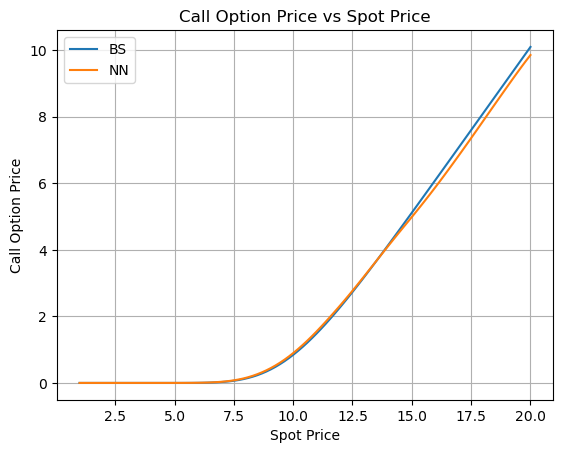

In [163]:
# visualize the predicted price by setting strike=10, r=0.01, sigma=0.2, T=1, and varying spot from 1 to 20
import matplotlib.pyplot as plt

S = np.linspace(1, 20, 100)
K = 10 + 0 * S
r = 0.01 + 0 * S
sigma = 0.2 + 0 * S
T = 1 + 0 * S

y_bs = bs_euro_vanilla_call(S, K, T, r, sigma)
y_net = net(torch.tensor(np.stack([S, K * np.ones_like(S), T * np.ones_like(S), r * np.ones_like(S), sigma * np.ones_like(S)], axis=1), dtype=torch.float32)).detach().numpy()[:, 0]
plt.plot(S, y_bs, label="BS")
plt.plot(S, y_net, label="NN")
plt.xlabel("Spot Price")
plt.ylabel("Call Option Price")
plt.title("Call Option Price vs Spot Price")
plt.legend()
plt.grid()
plt.show()

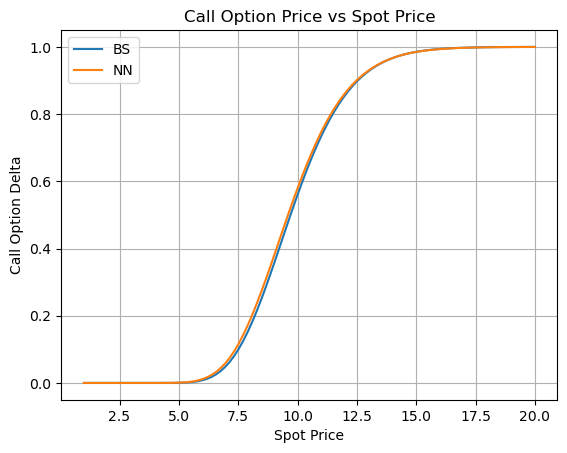

In [164]:
# visualize the predicted price by setting strike=10, r=0.01, sigma=0.2, T=1, and varying spot from 1 to 20
import matplotlib.pyplot as plt

S = np.linspace(1, 20, 100)
K = 10 + 0 * S
r = 0.01 + 0 * S
sigma = 0.2 + 0 * S
T = 1 + 0 * S

y_bs = delta_hedge_bs_euro_vanilla_call(S, K, T, r, sigma)
y_net = net(torch.tensor(np.stack([S, K * np.ones_like(S), T * np.ones_like(S), r * np.ones_like(S), sigma * np.ones_like(S)], axis=1), dtype=torch.float32)).detach().numpy()[:, 1]
plt.plot(S, y_bs, label="BS")
plt.plot(S, y_net, label="NN")
plt.xlabel("Spot Price")
plt.ylabel("Call Option Delta")
plt.title("Call Option Price vs Spot Price")
plt.legend()
plt.grid()
plt.show()